<a href="https://colab.research.google.com/github/keripikkaneboo/Machine-Learning/blob/main/UTS/Classification%20Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --id 1Q818R7QL09aCq1TNURGs_a_BKD8IquAe

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Q818R7QL09aCq1TNURGs_a_BKD8IquAe
From (redirected): https://drive.google.com/uc?id=1Q818R7QL09aCq1TNURGs_a_BKD8IquAe&confirm=t&uuid=d62df9b0-5a4e-4bd7-b765-f19b6144cc15
To: /content/KlasifikasiUTS.csv
100% 151M/151M [00:02<00:00, 70.2MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [4]:
#Load the dataset
df = pd.read_csv("/content/KlasifikasiUTS.csv")

# Display basic information about the dataset
print("Dataset Information:")
print(f"Shape: {df.shape}")
print("\nData types:")
print(df.dtypes)
print("\nSample data:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

Dataset Information:
Shape: (284807, 31)

Data types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Sample data:
   Time        V1        V2        V3        V4        V5        V6        V7        V8        V9       V10       V11       V12       V13       V14       V15       V16       V17       V18       V19       V20       V21       V22       V23       V24       V25       V26       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321

In [5]:
# Handle missing values
def handle_missing_values(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    # For numeric columns, impute with median
    if len(numeric_cols) > 0:
        numeric_imputer = SimpleImputer(strategy='median')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

    # For categorical columns, impute with most frequent value
    if len(categorical_cols) > 0:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

    return df

df = handle_missing_values(df)

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")


Duplicate rows: 1081
Shape after removing duplicates: (283726, 31)


In [6]:
# Step 2: Feature Selection
# -----------------------

# Identify target column (assuming the last column is the target)
# This should be adjusted based on the actual dataset
target_col = df.columns[-1]
print(f"\nTarget column: {target_col}")
X = df.drop(columns=[target_col])
y = df[target_col]

# Check if the target is categorical, and if so, encode it
if pd.api.types.is_object_dtype(y):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print(f"Target classes: {label_encoder.classes_}")
    print(f"Encoded target: {np.unique(y)}")

# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("\nNumeric features:", numeric_features.tolist())
print("Categorical features:", categorical_features.tolist())


Target column: Class

Numeric features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Categorical features: []


In [7]:
# A. Remove constant and quasi-constant features
def remove_constant_features(X, threshold=0.01):
    constant_filter = VarianceThreshold(threshold=threshold)
    constant_filter.fit(X[numeric_features])
    constant_features = [feature for feature, variance in zip(numeric_features, constant_filter.variances_) if variance <= threshold]

    print(f"Constant or quasi-constant features (threshold={threshold}):")
    print(constant_features)

    return constant_features

constant_features = remove_constant_features(X)

Constant or quasi-constant features (threshold=0.01):
[]


In [8]:
# B. Find duplicate features
def find_duplicate_features(X):
    duplicate_features = []
    for i in range(len(numeric_features)):
        for j in range(i+1, len(numeric_features)):
            if X[numeric_features[i]].equals(X[numeric_features[j]]):
                duplicate_features.append(numeric_features[j])

    print("\nDuplicate features:")
    print(duplicate_features)

    return duplicate_features

duplicate_features = find_duplicate_features(X)


Duplicate features:
[]


In [12]:
def correlation_analysis(X, numeric_features, threshold=0.8):
    if len(numeric_features) > 1:
        correlation_matrix = X[numeric_features].corr().abs()
        upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

        print(f"\nHighly correlated features (threshold={threshold}):")
        print(to_drop)

        # Plot correlation matrix
        plt.figure(figsize=(14, 12))
        sns.heatmap(
            correlation_matrix,
            annot=False,  # ganti ke True jika tetap ingin nilai korelasi ditampilkan
            cmap='coolwarm',
            fmt='.2f',
            linewidths=0.5,
            cbar=True,
            square=True,
            xticklabels=True,
            yticklabels=True
        )
        plt.xticks(rotation=45, ha='right')
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

        return to_drop
    else:
        print("\nNot enough numeric features for correlation analysis")
        return []


Highly correlated features (threshold=0.8):
[]


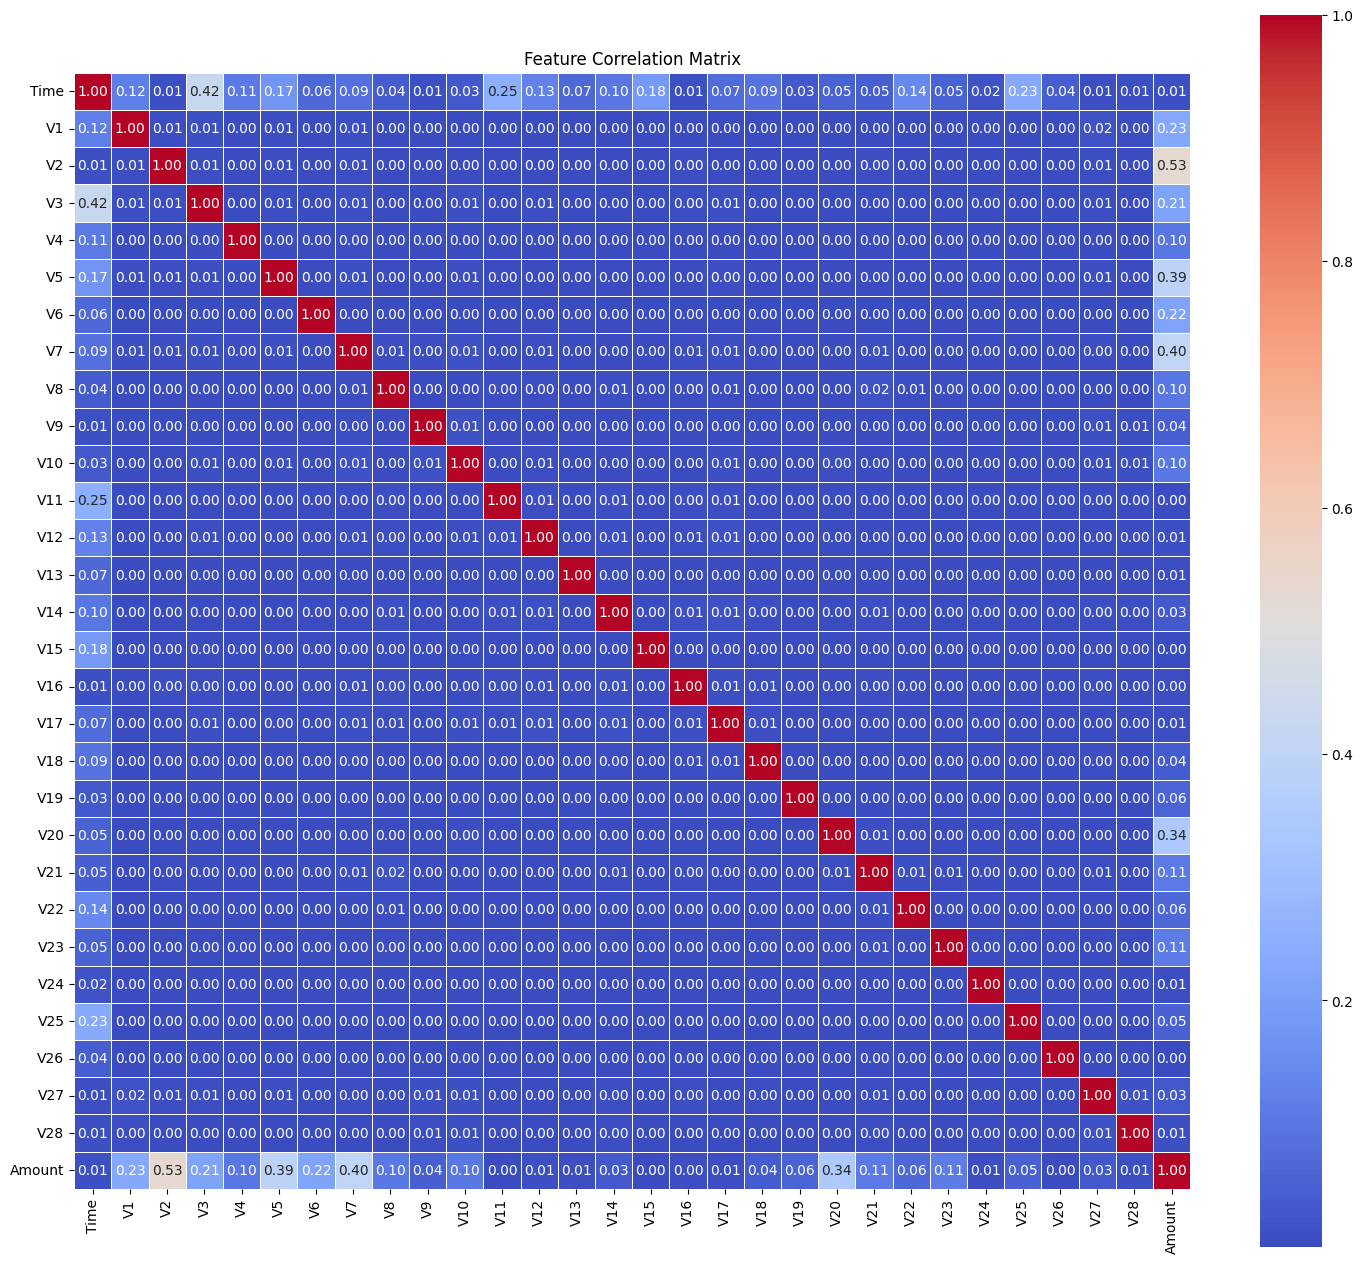

In [21]:
# C. Feature correlation analysis
def correlation_analysis(X, threshold=0.8):
    if len(numeric_features) > 1:
        correlation_matrix = X[numeric_features].corr().abs()
        upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

        print(f"\nHighly correlated features (threshold={threshold}):")
        print(to_drop)

        # Plot correlation matrix
        plt.figure(figsize=(18, 16))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True, square=True, xticklabels=True, yticklabels=True)
        plt.title(f'Feature Correlation Matrix')
        plt.show()

        return to_drop
    else:
        print("\nNot enough numeric features for correlation analysis")
        return []

correlated_features = correlation_analysis(X)


Mutual Information Scores:
   Feature  MI Score
17     V17  0.007873
14     V14  0.007746
12     V12  0.007220
10     V10  0.007150
11     V11  0.006450
16     V16  0.005752
4       V4  0.004587
3       V3  0.004583
18     V18  0.003875
9       V9  0.003854
7       V7  0.003630
2       V2  0.002920
27     V27  0.002166
21     V21  0.002139
5       V5  0.002065
6       V6  0.002000
1       V1  0.001851
28     V28  0.001607
8       V8  0.001600
29  Amount  0.001416
0     Time  0.001316
19     V19  0.001132
20     V20  0.000904
23     V23  0.000471
24     V24  0.000364
25     V25  0.000251
26     V26  0.000239
22     V22  0.000126
13     V13  0.000085
15     V15  0.000023


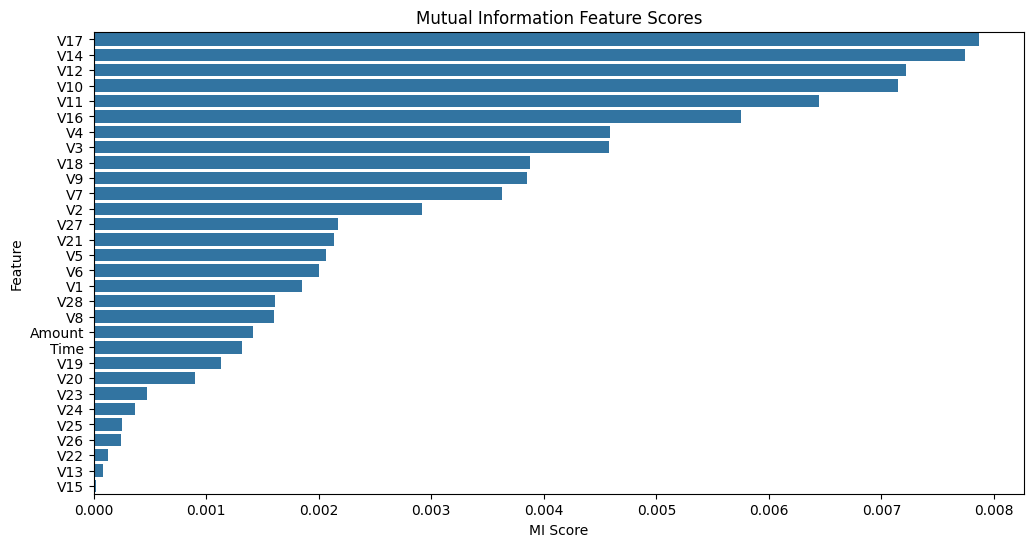

In [22]:
# D. Mutual Information for feature selection
def mutual_info_selection(X, y, categorical_features, k=10):
    features_to_analyze = X.columns.difference(categorical_features)
    if len(features_to_analyze) > 0:
        if len(features_to_analyze) > k:
            mi_selector = SelectKBest(mutual_info_classif, k=k)
            mi_selector.fit(X[features_to_analyze], y)

            # Create a DataFrame with feature names and scores
            mi_scores = pd.DataFrame({
                'Feature': features_to_analyze,
                'MI Score': mi_selector.scores_
            }).sort_values(by='MI Score', ascending=False)

            print("\nMutual Information Scores:")
            print(mi_scores)

            # Plot MI scores
            plt.figure(figsize=(12, 6))
            sns.barplot(x='MI Score', y='Feature', data=mi_scores)
            plt.title('Mutual Information Feature Scores')
            plt.show()

            # Return the top k features
            return mi_scores.head(k)['Feature'].tolist()
        else:
            print(f"\nNot enough features for MI selection (need > {k}, have {len(features_to_analyze)})")
            return features_to_analyze.tolist()
    else:
        print("\nNo features available for mutual information analysis")
        return []

top_mi_features = mutual_info_selection(X, y, categorical_features)

In [23]:
# E. Chi-Square Test for categorical features
def chi_square_selection(X, y, categorical_features, k=10):
    if len(categorical_features) > 0:
        # One-hot encode categorical features
        X_encoded = pd.get_dummies(X[categorical_features], drop_first=True)

        if X_encoded.shape[1] > 0:
            if X_encoded.shape[1] > k:
                chi2_selector = SelectKBest(chi2, k=min(k, X_encoded.shape[1]))
                chi2_selector.fit(X_encoded, y)

                # Get feature names after one-hot encoding
                feature_names = X_encoded.columns

                chi2_scores = pd.DataFrame({
                    'Feature': feature_names,
                    'Chi2 Score': chi2_selector.scores_
                }).sort_values(by='Chi2 Score', ascending=False)

                print("\nChi-Square Test Scores:")
                print(chi2_scores)

                # Plot Chi2 scores
                plt.figure(figsize=(12, 6))
                sns.barplot(x='Chi2 Score', y='Feature', data=chi2_scores)
                plt.title('Chi-Square Feature Scores')
                plt.show()

                # Return the top k features
                return chi2_scores.head(k)['Feature'].tolist()
            else:
                print(f"\nNot enough encoded categorical features for Chi2 selection (need > {k}, have {X_encoded.shape[1]})")
                return feature_names.tolist()
        else:
            print("\nNo features available after one-hot encoding for Chi2 analysis")
            return []
    else:
        print("\nNo categorical features available for Chi2 analysis")
        return []

top_chi2_features = chi_square_selection(X, y, categorical_features)


No categorical features available for Chi2 analysis



ANOVA F-Test Scores:
   Feature   ANOVA Score
17     V17  30923.969703
14     V14  26719.606942
12     V12  19029.929570
10     V10  12697.850513
16     V16  10302.274423
3       V3   9755.675863
7       V7   8685.536141
11     V11   6447.910427
4       V4   4826.048761
18     V18   3183.658090
1       V1   2555.783605
9       V9   2530.490402
5       V5   2204.804198
2       V2   2046.487425
6       V6    548.236966
19     V19    321.270696
8       V8    310.590168
21     V21    197.244229
27     V27    136.044078
20     V20    131.045321
0     Time     43.346393
28     V28     26.601443
24     V24     14.750416
23     V23     11.380500
29  Amount      9.469308
22     V22      6.776920
26     V26      5.160073
13     V13      4.308772
15     V15      3.088960
25     V25      2.909893


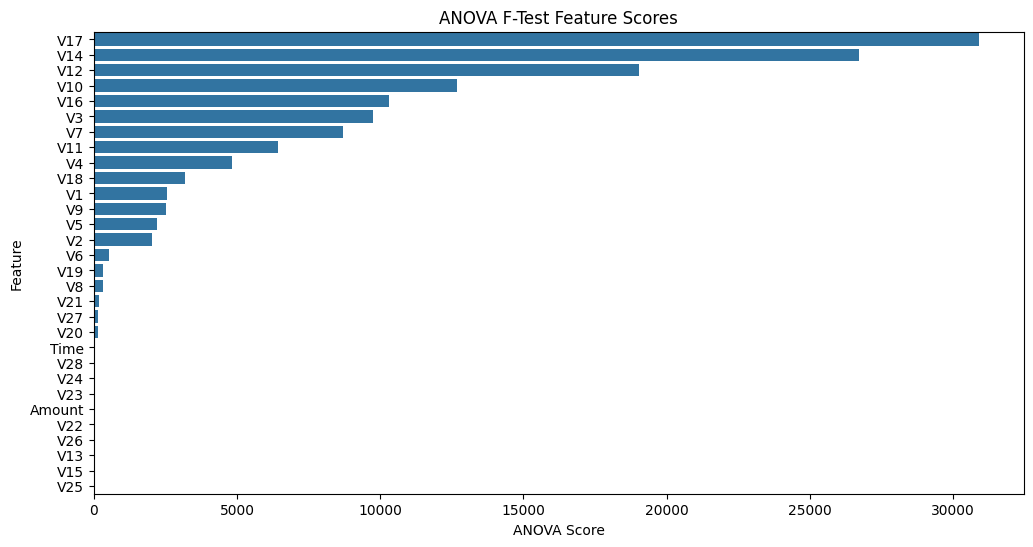

In [24]:
# F. ANOVA F-test for numerical features
def anova_selection(X, y, numeric_features, k=10):
    if len(numeric_features) > 0:
        if len(numeric_features) > k:
            anova_selector = SelectKBest(f_classif, k=k)
            anova_selector.fit(X[numeric_features], y)

            anova_scores = pd.DataFrame({
                'Feature': numeric_features,
                'ANOVA Score': anova_selector.scores_
            }).sort_values(by='ANOVA Score', ascending=False)

            print("\nANOVA F-Test Scores:")
            print(anova_scores)

            # Plot ANOVA scores
            plt.figure(figsize=(12, 6))
            sns.barplot(x='ANOVA Score', y='Feature', data=anova_scores)
            plt.title('ANOVA F-Test Feature Scores')
            plt.show()

            # Return the top k features
            return anova_scores.head(k)['Feature'].tolist()
        else:
            print(f"\nNot enough numeric features for ANOVA selection (need > {k}, have {len(numeric_features)})")
            return numeric_features.tolist()
    else:
        print("\nNo numeric features available for ANOVA analysis")
        return []

top_anova_features = anova_selection(X, y, numeric_features)

In [25]:
# Combine all feature selection results
features_to_drop = list(set(constant_features + duplicate_features + correlated_features))
print("\nFeatures to drop based on all selection methods:")
print(features_to_drop)

# Keep important features from MI, Chi2, and ANOVA
important_features = list(set(top_mi_features + top_chi2_features + top_anova_features))

# Features to keep
features_to_keep = [feature for feature in X.columns if feature not in features_to_drop or feature in important_features]
print("\nFeatures to keep:")
print(features_to_keep)

# Update X with selected features
X_selected = X[features_to_keep]
print(f"\nShape after feature selection: {X_selected.shape}")


Features to drop based on all selection methods:
[]

Features to keep:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

Shape after feature selection: (283726, 30)


In [26]:
# Step 3: Feature Engineering
# ------------------------

# A. Handle categorical features
def handle_categorical_features(X, categorical_features):
    X_processed = X.copy()

    # Apply one-hot encoding for categorical features
    categorical_cols = [col for col in categorical_features if col in X.columns]

    if len(categorical_cols) > 0:
        X_processed = pd.get_dummies(X_processed, columns=categorical_cols, drop_first=True)
        print(f"\nShape after one-hot encoding: {X_processed.shape}")

    return X_processed

X_processed = handle_categorical_features(X_selected, categorical_features)

# B. Feature scaling
def scale_features(X):
    # Apply standard scaling to numeric features
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

    if len(numeric_cols) > 0:
        scaler = StandardScaler()
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    return X, scaler

X_scaled, scaler = scale_features(X_processed)
print(f"\nShape after scaling: {X_scaled.shape}")


Shape after scaling: (283726, 30)


In [37]:
# Step 4: Model Training and Evaluation
# ----------------------------------

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(random_state=42, probability=True),  # Enable probability for ROC curve
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42)
}


Training set shape: (226980, 30)
Testing set shape: (56746, 30)



Classification type: Binary (2 classes)


Training Logistic Regression...


Training Decision Tree...


Training K-Nearest Neighbors...


Training SVM...


Training AdaBoost...


Training Bagging...

Model Performance Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.999189   0.999126  0.999189  0.999095
1        Decision Tree  0.998978   0.999013  0.998978  0.998994
2  K-Nearest Neighbors  0.999489   0.999476  0.999489  0.999448
3                  SVM  0.999418   0.999410  0.999418  0.999358
4             AdaBoost  0.999207   0.999160  0.999207  0.999176
5              Bagging  0.999454   0.999430  0.999454  0.999414


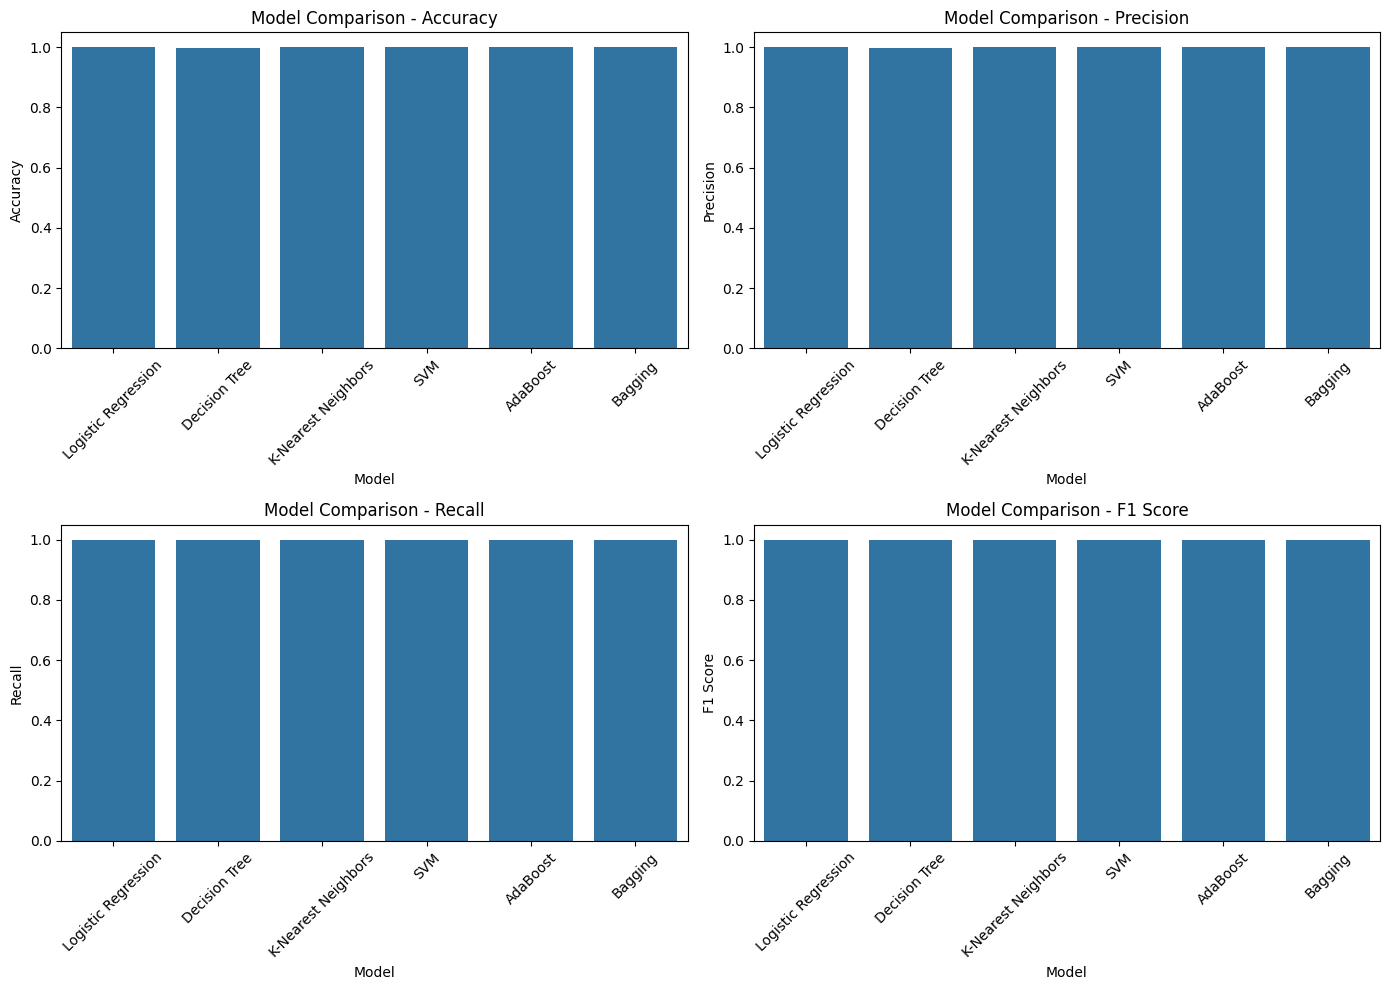

In [38]:
# Train and evaluate each model
results = []
model_predictions = {}
model_probabilities = {}

# Check if binary or multi-class classification
n_classes = len(np.unique(y))
is_binary = (n_classes == 2)

print(f"\nClassification type: {'Binary' if is_binary else 'Multi-class'} ({n_classes} classes)")

for name, model in models.items():
    print(f"\n\nTraining {name}...")
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    model_predictions[name] = y_pred

    # Get prediction probabilities if the model supports it
    try:
        y_prob = model.predict_proba(X_test)
        model_probabilities[name] = y_prob
    except:
        print(f"Warning: {name} doesn't support predict_proba, skipping ROC/AUC for this model")
        model_probabilities[name] = None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Create a DataFrame with all results for easier comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

# Plot model performances - Bar Chart Comparison
plt.figure(figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



=== Detailed Evaluation for Logistic Regression ===

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56656
         1.0       0.89      0.56      0.68        90

    accuracy                           1.00     56746
   macro avg       0.95      0.78      0.84     56746
weighted avg       1.00      1.00      1.00     56746



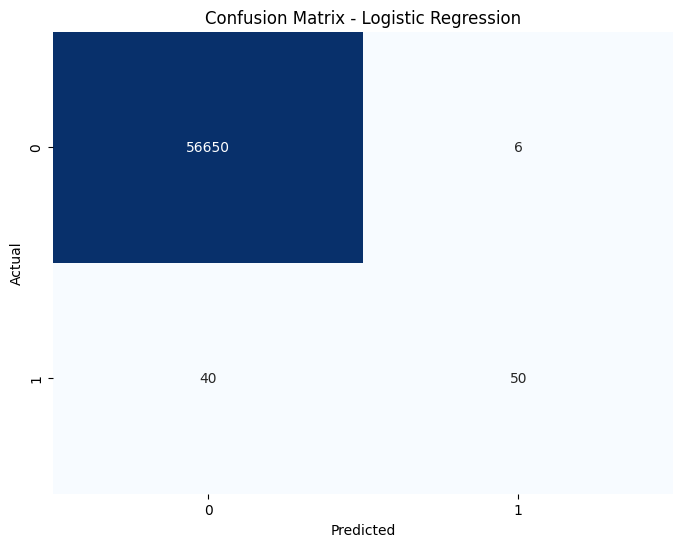

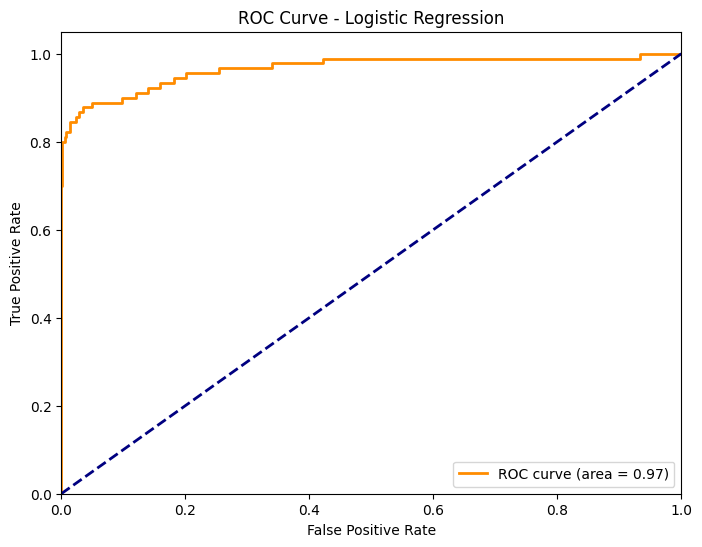



=== Detailed Evaluation for Decision Tree ===

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56656
         1.0       0.67      0.71      0.69        90

    accuracy                           1.00     56746
   macro avg       0.83      0.86      0.84     56746
weighted avg       1.00      1.00      1.00     56746



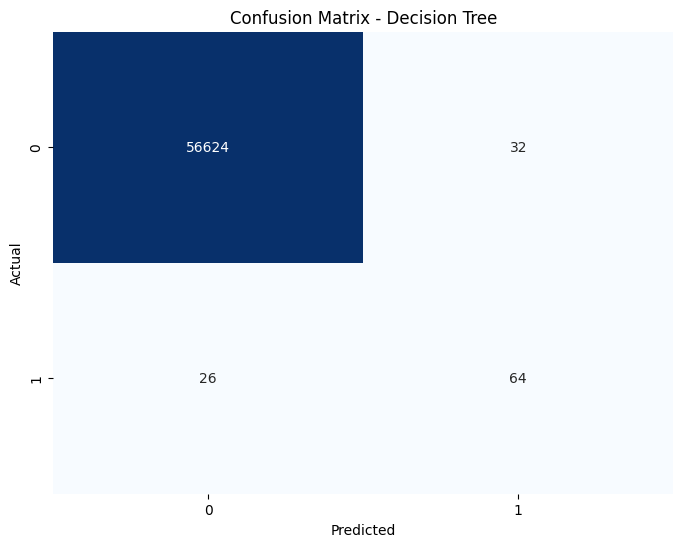

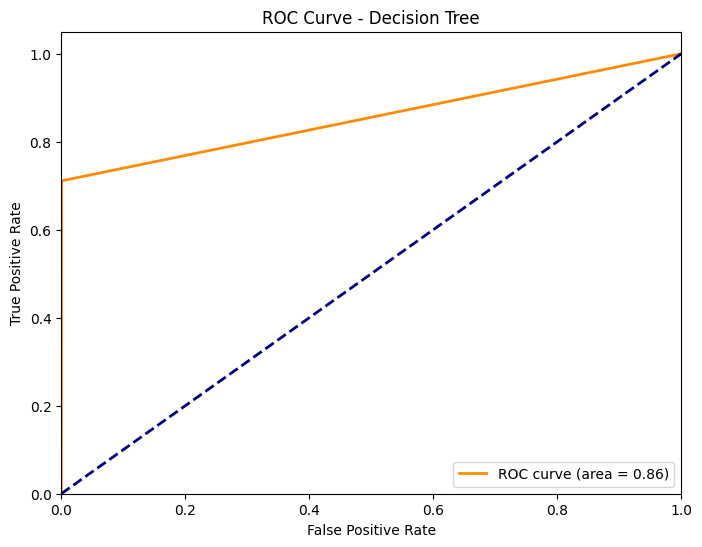



=== Detailed Evaluation for K-Nearest Neighbors ===

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56656
         1.0       0.97      0.70      0.81        90

    accuracy                           1.00     56746
   macro avg       0.98      0.85      0.91     56746
weighted avg       1.00      1.00      1.00     56746



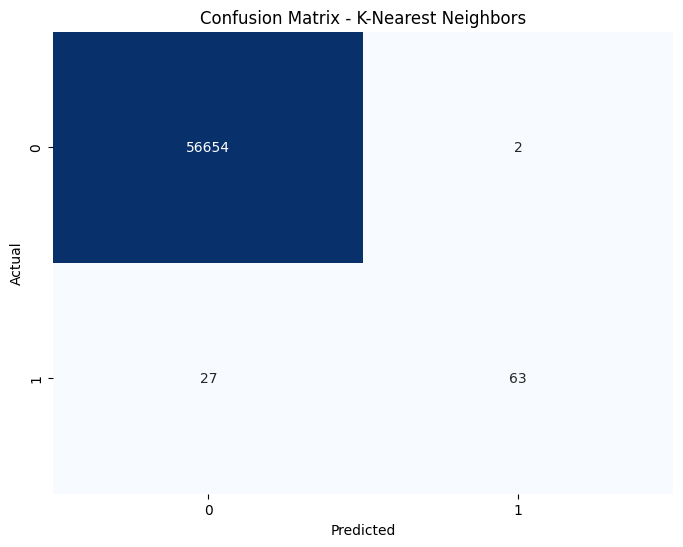



=== Detailed Evaluation for SVM ===

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56656
         1.0       0.98      0.64      0.78        90

    accuracy                           1.00     56746
   macro avg       0.99      0.82      0.89     56746
weighted avg       1.00      1.00      1.00     56746



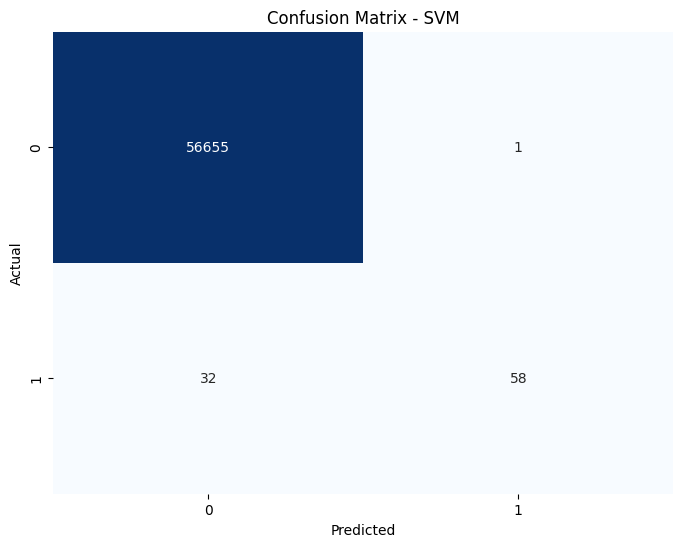



=== Detailed Evaluation for AdaBoost ===

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56656
         1.0       0.79      0.68      0.73        90

    accuracy                           1.00     56746
   macro avg       0.90      0.84      0.87     56746
weighted avg       1.00      1.00      1.00     56746



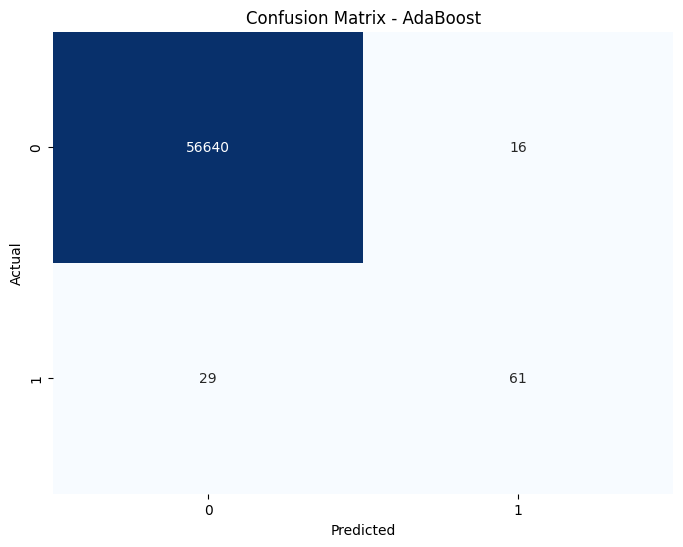

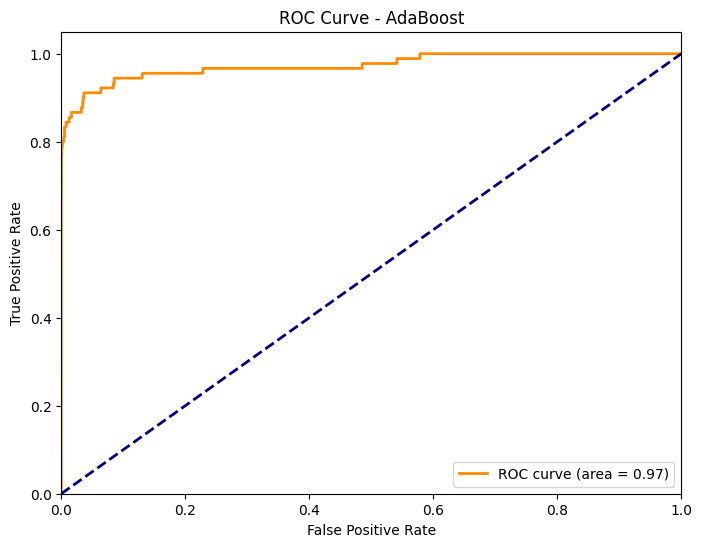



=== Detailed Evaluation for Bagging ===

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56656
         1.0       0.94      0.70      0.80        90

    accuracy                           1.00     56746
   macro avg       0.97      0.85      0.90     56746
weighted avg       1.00      1.00      1.00     56746



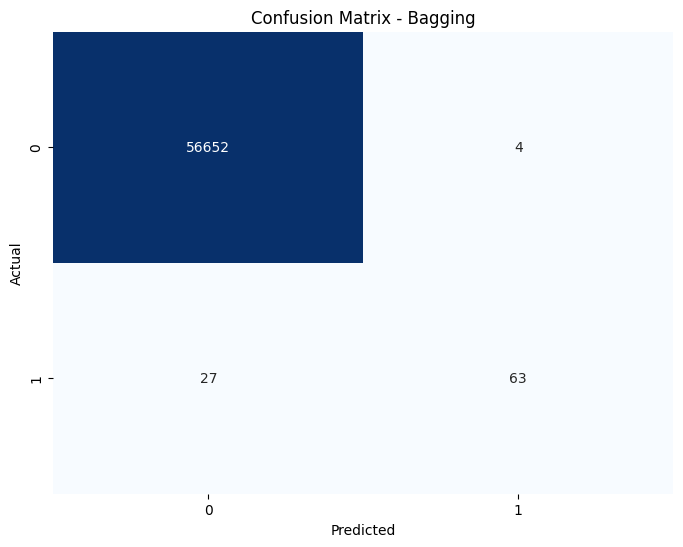

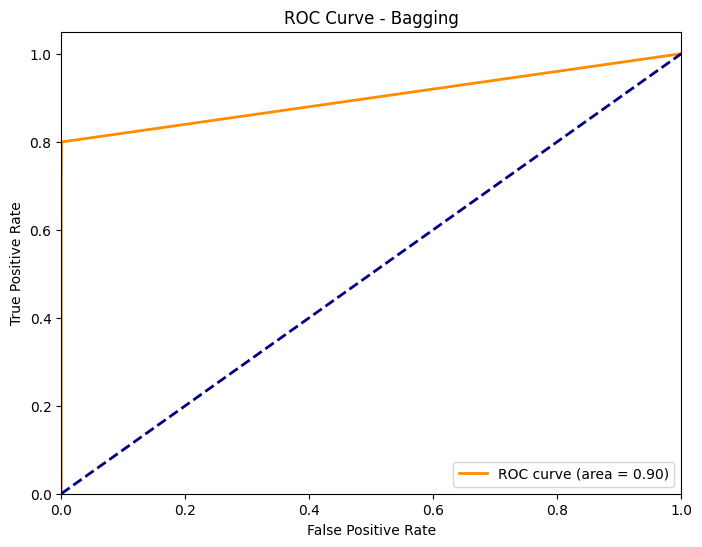

In [39]:
# Detailed evaluation for each model - confusion matrices and ROC/AUC
for name in models.keys():
    y_pred = model_predictions[name]
    y_prob = model_probabilities[name]

    print(f"\n\n=== Detailed Evaluation for {name} ===")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve and AUC (for binary classification or one-vs-rest for multi-class)
    if y_prob is not None:
        if is_binary:
            # Binary classification
            fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc='lower right')
            plt.show()
        else:
            # Multi-class classification - one vs rest
            n_classes = y_prob.shape[1]
            fpr = {}
            tpr = {}
            roc_auc = {}

            plt.figure(figsize=(10, 8))

            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

                plt.plot(fpr[i], tpr[i], lw=2,
                        label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Multi-class ROC - {name}')
            plt.legend(loc='lower right')
            plt.show()

            # Compute macro-average ROC curve and ROC area
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            macro_roc_auc = auc(all_fpr, mean_tpr)

            plt.figure(figsize=(8, 6))
            plt.plot(all_fpr, mean_tpr, color='darkorange', lw=2,
                    label=f'Macro-average ROC (area = {macro_roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Macro-average ROC - {name}')
            plt.legend(loc='lower right')
            plt.show()

In [42]:
# Find and highlight the best model based on different metrics
best_model = {
    'Accuracy': results_df.loc[results_df['Accuracy'].idxmax()]['Model'],
    'Precision': results_df.loc[results_df['Precision'].idxmax()]['Model'],
    'Recall': results_df.loc[results_df['Recall'].idxmax()]['Model'],
    'F1 Score': results_df.loc[results_df['F1 Score'].idxmax()]['Model']
}

print("\n===== BEST MODEL BY METRIC =====")
for metric, model in best_model.items():
    print(f"Best model by {metric}: {model} ({results_df.loc[results_df['Model'] == model, metric].values[0]:.4f})")

# Create a summary table highlighting which model is best for each metric
summary_table = pd.DataFrame(columns=['Metric', 'Best Model', 'Score'])
for i, (metric, model) in enumerate(best_model.items()):
    score = results_df.loc[results_df['Model'] == model, metric].values[0]
    summary_table.loc[i] = [metric, model, score]

print("\nSummary Table:")
print(summary_table)

# Overall recommendation based on F1 Score (balance between precision and recall)
f1_best_model = best_model['F1 Score']
f1_best_score = results_df.loc[results_df['Model'] == f1_best_model, 'F1 Score'].values[0]

print(f"\nRECOMMENDED MODEL: {f1_best_model} with F1 Score of {f1_best_score:.4f}")
print("This model provides the best balance between precision and recall.")


===== BEST MODEL BY METRIC =====
Best model by Accuracy: K-Nearest Neighbors (0.9995)
Best model by Precision: K-Nearest Neighbors (0.9995)
Best model by Recall: K-Nearest Neighbors (0.9995)
Best model by F1 Score: K-Nearest Neighbors (0.9994)

Summary Table:
      Metric           Best Model     Score
0   Accuracy  K-Nearest Neighbors  0.999489
1  Precision  K-Nearest Neighbors  0.999476
2     Recall  K-Nearest Neighbors  0.999489
3   F1 Score  K-Nearest Neighbors  0.999448

RECOMMENDED MODEL: K-Nearest Neighbors with F1 Score of 0.9994
This model provides the best balance between precision and recall.


# Penjelasan  Setiap Model yang ada

| Model | Penjelasan |
|:--|:--|
| **Linear Regression** | Model dasar yang mencari garis lurus terbaik untuk meminimalkan selisih antara prediksi dan nilai aktual. |
| **Decision Tree Regressor** | Memisahkan data menjadi beberapa region menggunakan aturan if-then-else untuk melakukan prediksi. Sangat efektif untuk hubungan non-linear. |
| **KNeighbors Regressor** | Membuat prediksi dengan menghitung rata-rata nilai target dari tetangga terdekat di ruang fitur. Sensitif terhadap skala data. |
| **Bagging Regressor** | Ensemble dari banyak regressor sederhana (contohnya pohon keputusan kecil) dengan teknik bootstrap aggregation untuk mengurangi variansi. |
| **AdaBoost Regressor** | Metode boosting yang menekankan pembelajaran pada data yang sulit diprediksi di iterasi berikutnya, efektif meningkatkan performa model sederhana. |
| **SVR (Support Vector Regressor)** | Menerapkan konsep margin optimal seperti SVM, tetapi untuk regresi. Dapat mengatasi hubungan non-linear dengan kernel trick. |

---

### 1. Model Machine learning menunjukkan AUC-ROC tinggi (0.92) tetpai presisi sangat rendah (15%) pada dataset tersebut. Jelaskan faktor penyebab utamanya dan bagaimana strategi tuning hyperparameter dapat meningkatkan presisi tanpa mengorbankan AUC-ROC secara signifikan? mengapa Recall menjadi pertimbangan kritis? bagaimana hubungannya dengan cost false negative?
- **Penyebab Utama**  
  - **Imbalanced classes**: Model memeringkat positif dengan akurasi relatif bagus (→ AUC tinggi), tetapi karena jarang benar-benar fraud (hanya 0,17%), kebanyakan prediksi “positif” adalah false positives → presisi drop.  
  - **Threshold default 0.5**: Banyak probabilitas fraud di bawah threshold tetapi tetap menghasilkan false alarms jika threshold terlalu rendah.  
- **Tuning Hyperparameter**  
  - **Adjust decision threshold**: Alih‐alih 0.5, cari threshold yang memaksimalkan presisi dengan masih menjaga TPR memadai—misalnya di ROC curve, pilih titik di mana precision-recall curve memotong trade-off ideal.  
  - **Class weight**: Gunakan `class_weight={1: w+, 0:1}` untuk menaikkan penalti false positive, atau gunakan `scale_pos_weight` pada XGBoost.  
  - **Regularisasi**: Pada LR/SVM atur parameter `C` (penalti) untuk mengurangi noise, sehingga probabilitas fraud lebih konservatif.  
  - **Ensemble tuning**: Pada AdaBoost turunkan `learning_rate` agar setiap estimator tidak “panas‐panasan” memprediksi outlier (false positives).  
  - **Hasil**: Karena AUC hanya melihat ranking, perubahan cutoff dan penalti jarang menurunkan AUC-ROC signifikan—kamu cuma memindahkan operating point di kurva.

- **Mengapa Recall Kritis**  
  - **Cost False Negative** (missed fraud) biasanya jauh lebih tinggi (kerugian finansial langsung) dibanding false positive (bisa di‐review manual).  
  - Menurunkan recall untuk memaksimalkan presisi bisa berarti banyak fraud terlewat. Idealnya pilih threshold atau weight sehingga recall tetap di atas batas minimal—misalnya ≥ 60–70%.

---

### 2. Sebuah fitur kategorikal dengan 1000 nilai unik (high-cardinality) digunakan dalam model machine learning. Jelaskan dampaknya terhadap estimasi koefisien dan stabilitas Presisi! Mengapa target encoding berisiko menyebabkan data leakage dalam kasus dataset tersebut, dan alternatif encoding apa yang lebih aman untuk mempertahankan AUC-ROC?
- **Dampak pada Koefisien & Presisi**  
  - Membuat matriks desain (dummy variables) sangat lebar → koefisien regresi menjadi tidak stabil (varian tinggi) dan mudah overfit ke kategori langka. Hasilnya presisi di data baru buruk.  
- **Risiko Data Leakage di Target Encoding**  
  - Jika kamu menghitung rata-rata fraud per kategori di seluruh dataset, informasi label dari test ikut terpakai dalam encoding train → evaluasi AUC-ROC validasi ter-overoptimistic.  
- **Alternatif Encoding Aman**  
  - **Hashing trick**: Pemetaan fungsi hash ke sejumlah bucket tetap, tanpa menggunakan statistik target. Preserves space dan tidak leak label.  
  - **Frequency encoding**: Ganti kategori dengan frekuensinya, juga tidak menggunakan target.  
  - **Embeddings dengan CV smoothing**: Jika ingin target-based, lakukan target encoding di tiap fold CV terpisah, dengan smoothing dan never-skip test fold.

---

### 3. Setelah normalisasi Min-Max, model SVM linear mengalami peningkatan Presisi dari 40% ke 60% tetapi Recall turun 20%. Analisis dampak normalisasi terhadap decision boundary dan margin kelas minoritas! Mengapa scaling yang sama mungkin memiliki efek berlawanan jika diterapkan pada model Gradient Boosting?
- **Dampak pada SVM**  
  - SVM memaksimalkan margin—ketika semua fitur di-[0,1], fitur minoritas (fraud) yang sebelumnya ber-dispersi kecil sekarang “terlihat” lebih besar secara relatif. Hyperplane bergeser sehingga memprioritaskan false positives berkurang (presisi naik), tapi banyak positif asli yang masuk di sisi negatif → recall turun.  
- **Mengapa Berbeda di Gradient Boosting**  
  - **Tree-based** mem‐split berdasarkan urutan ranking fitur, bukan jarak Euclidean. Scaling biasanya **tidak** mengubah urutan (rank) sehingga decision rules tidak terpengaruh. Namun, jika regularisasi leaf weights (misal L2 pada leaf values) diaktifkan, skala output residual berubah, bisa memengaruhi penyesuaian leaf → efek presisi/recall bisa berlawanan.

---

### 4. Eksperimen feature interaction dengan menggabungkan dua fitur melalui perkalian meningkatkan AUC-ROC dari 0.75 ke 0.82. Jelaskan mekanisme matematis di balik peningkatan ini dalam konteks decision boundary non-linear! Mengapa uji statistik seperti chi-square gagal mendeteksi interaksi semacam ini, dan metode domain knowledge apa yang dapat digunakan sebagai alternatif?
- **Mekanisme Matematis**  
  - Fungsi \(x_1 × x_2\) menambahkan dimensi polinomial kedua ke ruang fitur. Titik yang tadinya tidak dipisahkan linier menjadi terpisah di ruang 2D baru, sehingga hyperplane (atau split tree) dapat memisahkan cluster fraud vs non-fraud yang bergantung pada interaksi dua variabel.  
- **Kenapa Chi-Square Gagal**  
  - Uji chi-square hanya melihat asosiasi marginal tiap fitur dengan label, bukan hubungan joint antar fitur—interaksi non-linear tersembunyi tidak terdeteksi.  
- **Alternatif Berbasis Domain Knowledge**  
  - **Feature crossing manual**: misal `Amount × Time` untuk menangkap pola fraud yang terjadi di jam ekstrem dengan jumlah tinggi.  
  - **Association rule mining**: menemukan kombinasi kondisi (misal lokasi×metode) yang sering berkorelasi dengan fraud.

---

### 5. Dalam pipeline preprocessing, penggunaan oversampling sebelum pembagian train-test menyebabkan data leakage dengan AUC-ROC validasi 0.95 tetapi AUC-ROC testing 0.65. Jelaskan mengapa temporal split lebih aman untuk fraud detection, dan bagaimana stratified sampling dapat memperparah masalah ini! Bagaimana desain preprocessing yang benar untuk memastikan evaluasi metrik Presisi/Recall yang realistis?
- **Mengapa Bocor**  
  - SMOTE menghasilkan sampel sintetis berdasarkan tetangga train+test, sehingga test pun ikut “melahirkan” sampel yang mirip train → validasi terlayani bocoran informasi.  
- **Temporal Split Aman**  
  - Fraud detection tergantung waktu: pola “lama” bisa berbeda dengan pola “baru.” Membagi berdasarkan urutan waktu (train = transaksi s.d. t, test = transaksi sesudah t) mencegah info future masuk ke train.  
- **Stratified Sampling & Risiko**  
  - Stratified random split memastikan proporsi fraud sama tapi tetap i.i.d.—jika oversample sebelum split, distribusi minoritas bocor ke test dan train.  
- **Desain Preprocessing yang Benar**  
  1. **Temporal split** (atau stratified random split tanpa oversample).  
  2. **Fit scaler, selector** di train saja.  
  3. **Oversample** (SMOTE) **hanya** pada train hasil split tadi.  
  4. Transform test dengan scaler/selector yang sama, **tanpa oversample**.  
  5. Train model dan evaluasi recall/presisi di test sebenarnya.  

Dengan alur ini metrik presisi & recall yang didapat mencerminkan performa model di dunia nyata.